# COVID-19 notification rates (XML & JSON example)
We are going to use the [data on 14-day notification rate of new COVID-19 cases and deaths](https://www.ecdc.europa.eu/en/publications-data/data-national-14-day-notification-rate-covid-19) from the European Centre for Disease Prevention and Control. The data set contains information on the 14-day notification rate of newly reported COVID-19 cases per 100 000 population and the 14-day notification rate of reported deaths per million population by day and country. Each row contains the corresponding data for a certain day and per country. 

We first import some libraries that will be used: the first one is for "parsing" the XML file and the second for downloading the data from a given URL:

In [91]:
import xml.etree.ElementTree as et
import urllib.request as url

We download the XML data from the ECDC site (this takes some time, the file is around 15MB in size):

In [92]:
xml_url = "https://opendata.ecdc.europa.eu/covid19/nationalcasedeath/xml"
data = url.urlopen(xml_url).read()

Parse the XML data using the [ElementTree XML library](https://docs.python.org/3/library/xml.etree.elementtree.html):

In [93]:
root = et.fromstring(data)

The XML dataset uses Namespaces so we set a mapping from namespace prefix to the exact namespace URI:

In [94]:
ns = {'fme':"http://www.safe.com/xml/xmltables"}

And now we can extract the cases and deaths for Greece. The format of the XML conforms to the following:

```
<fme:Sheet1>
	<fme:country>Greece</fme:country>
	<fme:country_code>GRC</fme:country_code>
	<fme:continent>Europe</fme:continent>
	<fme:population>10718565</fme:population>
	<fme:indicator>cases</fme:indicator>
	<fme:weekly_count>0</fme:weekly_count>
	<fme:year_week>2020-06</fme:year_week>
	<fme:rate_14_day>0</fme:rate_14_day>
	<fme:cumulative_count>0</fme:cumulative_count>
	<fme:source>Epidemic intelligence, national weekly data</fme:source>
</fme:Sheet1>
```

According to the ["Data dictionary"](https://www.ecdc.europa.eu/sites/default/files/documents/2021-01-13_Variable_Dictionary_and_Disclaimer_national_weekly_data.pdf) the field `rate_14_day` contains the 14-day notification rate of reported COVID-19 cases per 100 000 population OR 14-day notification rate of reported deaths per 1 000 000 population. The field `indicator` differentiates between the cases and the deaths, while the `country` is the name of the country. 

We can use the [`findall`](https://docs.python.org/3/library/xml.etree.elementtree.html#xml.etree.ElementTree.Element.findall) method with [XPATH expressions](https://docs.python.org/3/library/xml.etree.elementtree.html#elementtree-xpath) to search for all `Sheet1` elements starting from the `root`. The XPATH expression `.//fme:Sheet1` means:
* Starting from the current element: `.`
* Going to any depth inside the current element: `//`
* Finding the `Sheet1` element of the namespace with prefix `fme`: `fme:Sheet1` 

In [95]:
all_sheets = root.findall(".//fme:Sheet1", ns)

Let's assume that we are interested only in the statistics for Greece. Therefore, we can use Python's ["list comprehensions"](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions) to filter and keep only the "sheets" that refer to Greece. The following code reads as follows:
   
> For each element in `all_sheets` find its child element with tag `country` in the `fme` namespace and take its text content. If this text is "Greece", append the child element to the list.

In [96]:
greek_sheets = [i for i in all_sheets if i.find("fme:country", ns).text == "Greece"]

We can now retrieve the numbers from these sheets. Some of the sheets do not contain the `rate_14_day` element so in the code below we filter out these sheets and keep the rest in the `valid_sheets` list. From this list of elements we separate the "deaths" from the "cases" element based on the content of the `indicator` element and create the `deaths_sheets` and `cases_sheets` lists. Finally, for each element in these lists we select the `rate_14_day` field and transform it to a float number:

In [97]:
valid_sheets = [i for i in greek_sheets if i.find("fme:rate_14_day", ns) is not None]
cases_sheets = [i for i in valid_sheets if i.find("fme:indicator", ns).text == 'cases']
deaths_sheets = [i for i in valid_sheets if i.find("fme:indicator", ns).text == 'deaths']
cases_rate = [float(i.find("fme:rate_14_day", ns).text) for i in cases_sheets]
deaths_rate = [float(i.find("fme:rate_14_day", ns).text) for i in deaths_sheets]

Finally, we can plot these numbers in a common plot using another library of Python:

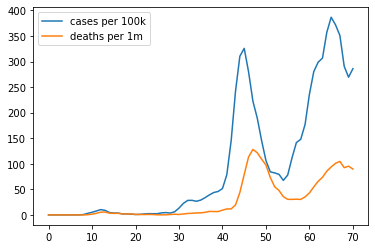

In [98]:
import matplotlib.pyplot as plt

plt.plot(cases_rate, label="cases per 100k")
plt.plot(deaths_rate, label="deaths per 1m")
plt.legend()

## Using the JSON data

The same thing can be done if instead of XML we download the JSON formatted data from the same ECDC site. The format is now easier to decipher: the content is a JSON list with JSON Objects containing the data that were represented as `Sheet1` elements in the XML format, as shown below
```
  [
   ...
  {
		"country" : "Greece",
		"country_code" : "GRC",
		"continent" : "Europe",
		"population" : 10718565,
		"indicator" : "cases",
		"weekly_count" : 66,
		"year_week" : "2020-10",
		"rate_14_day" : "0.681061317443147",
		"cumulative_count" : 73,
		"source" : "Epidemic intelligence, national weekly data"
	}
   ...
  ]
 ```

As you can see the format is simpler (no namespaces!) and indeed there are savings in file size (the JSON file is around 8 MBs). Also there is a simpler mapping between the format and the Python data structures: A JSON array is represented as a Python list and a JSON Object is represented as a Python Dictionary. 

We start by importing the `json` built-in library of Python that allows us to read the JSON data:

In [99]:
import json

We load the data from JSON URL as follows:

In [100]:
json_data = json.load(url.urlopen("https://opendata.ecdc.europa.eu/covid19/nationalcasedeath/json"))

In [101]:
valid_obj = [i for i in json_data if i["country"] == "Greece" and "rate_14_day" in i]
cases_obj = [i for i in valid_obj if i["indicator"] == 'cases']
deaths_obj = [i for i in valid_obj if i["indicator"]  == 'deaths']
cases_rate = [float(i["rate_14_day"]) for i in cases_obj]
deaths_rate = [float(i["rate_14_day"]) for i in deaths_obj]

Again, we plot the rates in the same way as above and the result should be identical:

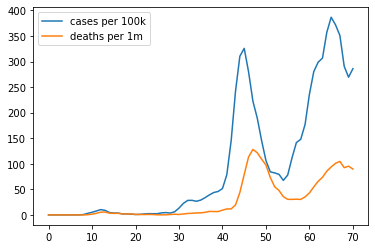

In [102]:
plt.plot(cases_rate, label="cases per 100k")
plt.plot(deaths_rate, label="deaths per 1m")
plt.legend()